In [1]:
# author - Richard Liao
# Dec 26 2016
# https://richliao.github.io/supervised/classification/2016/11/26/textclassifier-convolutional/
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os

os.environ['KERAS_BACKEND']='theano'

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.models import Sequential
from keras.layers.core import Activation
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout
from keras.models import Model
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split


# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


{'violence/terrorism': 1, 'political': 3, 'misc': 2}


0    syrian assad say syria killed damascus people ...
1    use osc copyrighted_material dissemination usa...
2    will year can people one country party make sa...
3    quot apos say the we it reuters terrorists ass...
4    baghdad iraq sunni killed bomb iraqi attacks w...
Name: topicFlat, dtype: object

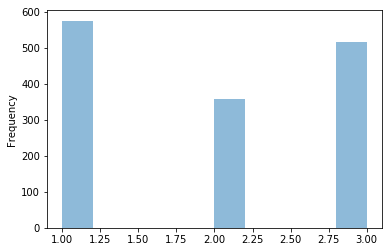

In [2]:
MAX_SEQUENCE_LENGTH = 1000 # top 30
MAX_NB_WORDS = 20000 # more than vocab size
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2


data_train = pd.read_csv('../result_all_windows_labels.csv')

# Cleanup - remove no labels
data_train = data_train[data_train['label'].notnull()]
data_train = data_train[data_train.label != 'environmental']
data_train = data_train[data_train.label != 'religious']
data_train = data_train[data_train.label != 'economical']


label_cat = {'violence/terrorism' : 1, 'misc': 2, 'political': 3, 
#              'religious': 4, 'economical': 5, 'environmental': 6
            }
print(label_cat) 


def to_category(x):
    return label_cat[x]

data_train['target'] = data_train.apply(lambda row: to_category(row['label']), axis=1)


data_train['target'].plot.hist(alpha=0.5)


texts = []
# Get corpus by joining all keywords
for index, row in data_train.iloc[ :, 2:32].iterrows():
    texts.append(u' '.join(row.tolist()))
    
data_train['topicFlat'] = texts

# texts = datdata_traina_train['topicFlat']

labels = data_train['target']

# print(labels)
data_train['topicFlat'].head()

In [3]:
%%time
    

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
# sequences = tokenizer.texts_to_matrix(texts, mode='tfidf')

print(sequences[0])
print (max(sequences, key=len))

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index)) # all the tokens in corpus
# print(word_index)

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
# print(data[0])

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

[4, 17, 1, 2, 16, 42, 7, 47, 178, 56, 30, 1014, 395, 8, 160, 22, 38, 12, 201, 3300, 142, 10, 3, 17, 1640, 202, 433, 396, 307, 82, 145, 649]
[1722, 4665, 4666, 157, 4667, 1792, 4668, 1596, 790, 4669, 2969, 2236, 4670, 137, 1173, 4671, 501, 719, 987, 2909, 4672, 4673, 394, 2911, 2912, 101, 2913, 790, 647, 1311, 1294, 2264, 2171, 1310, 2970, 790, 951, 790, 950, 2971, 4674, 2914, 1745, 43, 4675]
Found 6077 unique tokens.
Shape of data tensor: (1449, 1000)
Shape of label tensor: (1449, 4)
CPU times: user 104 ms, sys: 4 ms, total: 108 ms
Wall time: 112 ms


In [4]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_test = data[-nb_validation_samples:]
y_test = labels[-nb_validation_samples:]


print('Number of positive and negative reviews in traing and validation set ')
print (y_train.sum(axis=0))
print (y_test.sum(axis=0))

Number of positive and negative reviews in traing and validation set 
[  0. 466. 290. 404.]
[  0. 109.  67. 113.]


In [5]:
%%time

# https://www.kaggle.com/rtatman/glove-global-vectors-for-word-representation/data

GLOVE_DIR = "../data/"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.
CPU times: user 10.7 s, sys: 204 ms, total: 10.9 s
Wall time: 10.9 s


In [6]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [7]:
%%time


embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)


# Embedding(5000, 32, input_length=500)

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 15.4 ms


In [ ]:
%%time



sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(label_cat) + 1, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

print("model fitting - simplified convolutional neural network")
model.summary()

model_name = 'topicConvNet-Reg.h5'
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
best_model = ModelCheckpoint(model_name, verbose=1, save_best_only=True)

network_hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), 
          verbose=True, callbacks=[early_stop, best_model], validation_split=0.2,
          epochs=20, batch_size=50)

score, acc = model.evaluate(x_test, y_test, batch_size=50)
print('Test score:', score)
print('Test accuracy:', acc)

# print(network_hist.history)
plot_history(network_hist)


In [ ]:


# returns a compiled model
# identical to the previous one
# model = load_model('topicConvNet-Reg.h5')


In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [ ]:



embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

# applying a more complex convolutional approach
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(filters=128,filter_length=fsz, activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)
    
l_merge = Merge(mode='concat', concat_axis=1)(convs)
l_cov1= Conv1D(filters=128, kernel_size=5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(filters=128, kernel_size=5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(label_cat) + 1, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print("model fitting - more complex convolutional neural network")
model.summary()

model_name = 'topicConv_20.h5'
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
best_model = ModelCheckpoint(model_name, verbose=1, save_best_only=True)

network_hist = model.fit(x_train, y_train, validation_data=(x_train, y_train), 
          verbose=True, callbacks=[early_stop, best_model],
          epochs=20, batch_size=50)

score, acc = model.evaluate(x_train, y_train, batch_size=50)
print('Test score:', score)
print('Test accuracy:', acc)

# print(network_hist.history)
plot_history(network_hist)

In [ ]:

# EMBEDDING_DIM = 32
# embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_vector
        
# embedding_layer = Embedding(len(word_index) + 1,
#                             EMBEDDING_DIM,
#                             weights=[embedding_matrix],
#                             input_length=MAX_SEQUENCE_LENGTH,
#                             trainable=True)
# create the model
model = Sequential()
model.add(Embedding(len(word_index) + 1, 32, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(len(label_cat) + 1, activation='sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


model_name = 'topicConv_simple.h5'
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
best_model = ModelCheckpoint(model_name, verbose=1, save_best_only=True)

network_hist = model.fit(x_train, y_train, validation_data=(x_train, y_train), 
          verbose=True, callbacks=[early_stop, best_model],
          epochs=20, batch_size=50)

score, acc = model.evaluate(x_train, y_train, batch_size=50)
print('Test score:', score)
print('Test accuracy:', acc)

# print(network_hist.history)
plot_history(network_hist)